In [1]:
from simulation_functions import index, simulation_, plot
from interpolation_functions import T_K
from make_noise import simulate_noise
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sim = simulate_noise()
ts = sim[0]
fs = sim[1] # with noise

sampling = 5
# desired sampling for each curve
tk = np.array([T_K(sampling,ts[0])[0],T_K(sampling,ts[1])[0],T_K(sampling,ts[2])[0],T_K(sampling,ts[3])[0]]) # desired sampling is 3 days here

h=sampling
time_delays = sim[2]

# sinc matrix
matrix = []
for i in range(4):
    matrix.append(np.array([(ts[i][:,np.newaxis]+time_delays[i])-tk[i][np.newaxis,:]]))
matrix = np.array(matrix)
#A = np.sinc(matrix)
A = np.sinc(np.concatenate([matrix[0],matrix[1],matrix[2],matrix[3]],axis =0)/h)
#Y = fs[0][np.newaxis,:]
Y= np.concatenate([fs[0][np.newaxis,:],fs[1][np.newaxis,:],fs[2][np.newaxis,:],fs[3][np.newaxis,:]])

In [2]:
# multiplication functions:
noise_std = sim[3]#/sim[3]
def AT(X,A,Y, noise): 
    '''
    calculateS the weighted mean of A.T(Y-AX)
    input:
    X : array with shape k, solution of interpolation
    A : tensor of shape 4xkxs, sinc matrix
    Y : matrix of shape 4xs, magnitudes of original time sampling
    '''
    weighted_mean = 0
    nl, ns, nx = A.shape
    for i in range(nl):
        weighted_mean += ((4/noise[i])**2)*np.dot(A[i].T, Y[i] - A[i] @ X)
    
    return weighted_mean/np.sum(4/(noise**2))

def multiplication(X,S): # X.S
    '''
    multiplies X by S[i] and takes the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i]))
    this = np.array(this)
    return np.mean(this,axis=0)

def multiplication_T(X,S): # X.S.T

    '''
    multiplies X by S[i].T and take the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i].T))
    this = np.array(this)
    return np.mean(this,axis=0)

iteration 0
iteration 500
iteration 1000
iteration 1500
iteration 2000
iteration 2500
iteration 3000
iteration 3500
iteration 4000
iteration 4500


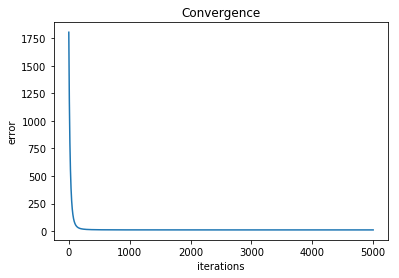

In [3]:
def linorm(S, nit):
    x0 = np.random.rand(S.shape[1])  # chose [1] per the implementation of the power iteration method in wiki
    x0 = x0 /np.linalg.norm(x0)
    for i in range(nit):
        x = multiplication(x0,S)#np.dot(x0,S)
        xn = np.linalg.norm(x)
        xp = x / xn#     
        y = multiplication_T(xp,S) # the S.T is done within the functionas S[i].T not S.T[i]
        yn = np.linalg.norm(y)  
        x0 = y / yn
    return 1./xn
mu = linorm(A,20)/170 # = 0.0038

X = np.random.rand(len(tk[0]))

count = 0
R = [np.sum(Y ** 2)]
epsilon = 0.3


while (R[-1] > epsilon) and (
        count < 5000):  # 5000 is a good amount of counts
    if count % 500 == 0:
        print('iteration {}'.format(count))
    X_new = X + mu * AT(X,A,Y, noise_std)
    X = X_new.copy()
    #X -= 0.1*X
    R.append(np.sum((Y - A @ X) ** 2.))
    count += 1


plt.title('Convergence')
plt.plot(np.array(R[1:]))
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()




In [5]:
cut = np.logical_and(X < np.max(Y), X > np.min(Y))

%matplotlib qt
plt.figure(figsize=(20,10))

plt.plot(ts[0], Y[0], 'o', label='light curve 1')
plt.plot(ts[1], Y[1], 'o', label='light curve 2')
plt.plot(ts[2], Y[2], 'o', label='light curve 3')
plt.plot(ts[3], Y[3], 'o', label='light curve 4')

plt.plot(tk[0][cut], X[cut], label='interpolated', color='black')
plt.xlabel('time[days]')
plt.ylabel('magnitude')
plt.title('sinc interpolated values')
plt.legend()
plt.savefig("figures/result_4xkxs_final.png")
plt.show()


wondering about: (to discuss in meeting)
- multiplication_T(X,S): X,S[i].T versus X,S.T[i]
- interpolation is not that good, /draft/4xkxs.py seems to interpolate better.
- we agreed that the standard deviation of the distribution of noise added to the data would be about the tenth
  of the power of the signal (sqrt(f1^2+f2^2+...)) but this standard deviation turns out to be way too large, especially compared to the noise from the real data which I took inspiration from to make the noise for the simulated data.
